__The workflow we will follow is__: <br>
1. __Get Data Ready__<br>
2. __Build or pick a pretrained model__<br>
> __2.1 Build a Training loop__<br>
> __2.2 Pick a loss func and an optimizer__<br>
3. __Fit the model to data and make predictions__<br>
4. __Evaluate the model__<br>
5. __Improve Through Experimentation__<br>
6. __Save And Reload the model__<br>

![title](workflow.png)

__torch.nn -> https://pytorch.org/docs/stable/nn.html__ <br>
It contains all the building blocks of a neural network

In [183]:
import torch
from torch import nn 
import matplotlib.pyplot as plt

# 1. Data Preparing And Loading

We are creating a dummy dataset with known parameters, and from the data we will make the deep learning algorithm learn these parameters and then compare the predictions

### Creating Data

In [184]:
# known parameters
weight = 0.7
bias = 0.3

# creating dataset with these parameters
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [185]:
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

### Training & Test Split

In [186]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [187]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualizing Data

In [188]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test,predictions=None):
    plt.figure(figsize=(10,7))
    
    #plot training data
    plt.scatter(train_data, train_labels, c='b', s=4, label='training data')
    
    #plot test data
    plt.scatter(test_data, test_labels, c='g', s=4, label='testing data')
    
    # if predictions then plot 
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='predictions')
        
    # show the legend
    plt.legend(prop={'size':14})

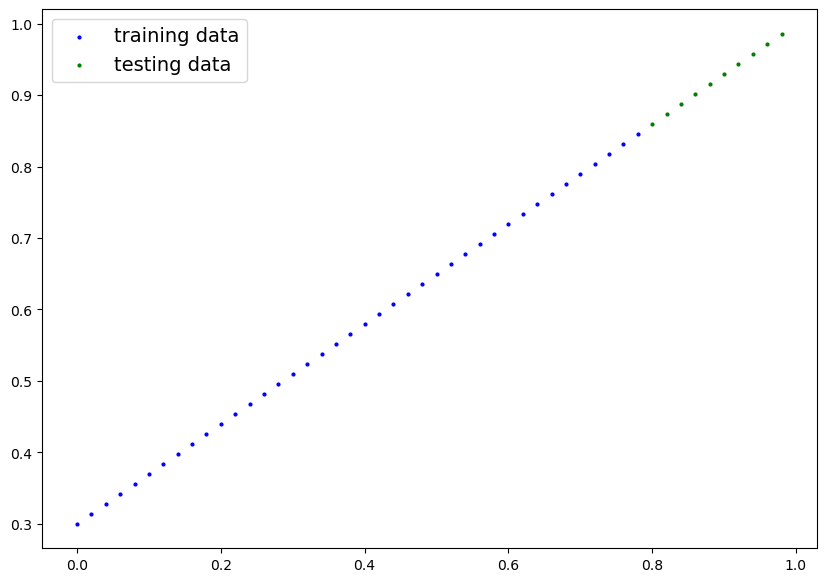

In [189]:
plot_predictions()

# 2. Building A Model

__What does this model do?__ <br>
* *Start With Random values*
* *Look at training data and adjust the random values to better represent the training data*

__How does it do so?__ <br>
* *Gradient Descent* 
* *Backpropagation*

![title](model.jpeg)

In [190]:
# create a linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True, 
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    # forward method to define the flow of the computation
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Pytorch Model Building Essentials
* torch.nn - contain all of the building blocks for computational graph (a network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a pytorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural networks modules, if you subclass it you should overwrite forward()
* torch.optim - contains optimizers, they help the gradient descent algorithm

In [191]:
# create a random seed
torch.manual_seed(42)

# creting instance of the model
model_0 = LinearRegressionModel()

# check parameters 
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [192]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Predictions Using torch.inference_mode()
__torch.inference_mode() -> https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html__

In [193]:
with torch.inference_mode():
    y_preds = model_0(X_test)
    
# inference_mode() is fairly new in pytorch so old pytorch code may also contain it does the same thing 
# with torch.no_grad()
#     y_preds = model(X_test) 

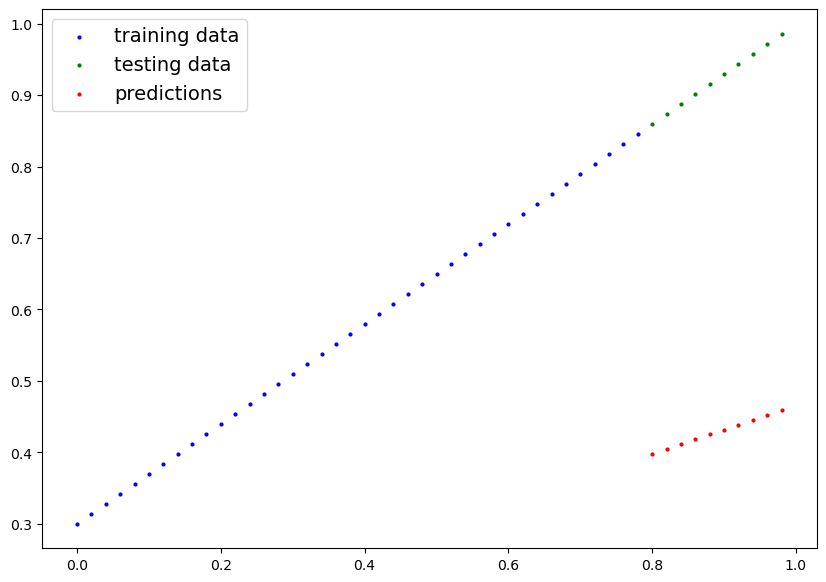

In [194]:
plot_predictions(predictions=y_preds)

## 2.1 Training Loop
The whole idea of training is for the model to move from some random parameters to a better parameters, or in other words from a poor representation of the data to a better representation <br>
To measure how poor our estimate is, we use loss fn <br>


__Things we need to train the model__<br>
* *__Loss Function__* : to measurehow wrong our model's predictions are
* *__Optimizer__* : a function or an algorithm that adjusts the attributes of the neural network, such as weights and learning rates


__Pytorch Loss Funcs -> https://pytorch.org/docs/stable/nn.html#loss-functions__ <br>
__Pytorch Optimizers -> https://pytorch.org/docs/stable/optim.html__

In [195]:
# set up a loss function
loss_fn = nn.L1Loss()

# set up an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [196]:
loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

__Building a Training And Testing Loop in Pytorch__ <br>
1. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` func
2. Calculate Loss (compare forward_pass predictions to true_labels)
3. Optimizer zero grad 
4. Loss backward (back_propagation)
5. Optimizer step (use optimizer to update the model's parameters)

In [197]:
torch.manual_seed(42)

epochs = 100
epochs_list = []
train_loss_list = []
test_loss_list = []


# 1. loop through the data
for  epoch in range(epochs):
    epochs_list.append(epoch)
    # set model to training mode
    model_0.train() # sets all parameter's require_grad to True
    
    # 2. forward pass
    y_preds = model_0(X_train)
    
    # 3. calc loss
    loss = loss_fn(y_preds, y_train)
    train_loss_list.append(loss.item())
    
    # 4. optimizer zero grad (by def the optim changes will accumulate through the loop so we zero them manually)
    optimizer.zero_grad()
    
    # 5. perform back_propagation()
    loss.backward()
    
    # 6. optimzier step
    optimizer.step()
    
    
    # we are writing the tesing Loop
    model_0.eval() # turns off diff settigs in the model not needed for evaluation/testing (eg. dropout, batchnorm)
    with torch.inference_mode(): # turns off gradient tracking
        # forward pass
        test_preds = model_0(X_test)
        
        # calc loss
        test_loss = loss_fn(test_preds, y_test)
        test_loss_list.append(test_loss)
        
    if epoch%10 == 0:
        print(f"Epoch: {epoch+1} |  Loss: {loss} | Test_Loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 1 |  Loss: 0.31288138031959534 | Test_Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 11 |  Loss: 0.1976713240146637 | Test_Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 21 |  Loss: 0.08908725529909134 | Test_Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 31 |  Loss: 0.053148526698350906 | Test_Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 41 |  Loss: 0.04543796554207802 | Test_Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 51 |  Loss: 0.04167863354086876 | Test_Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 61 |  Loss: 0.03818932920694351 | Test_Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor(

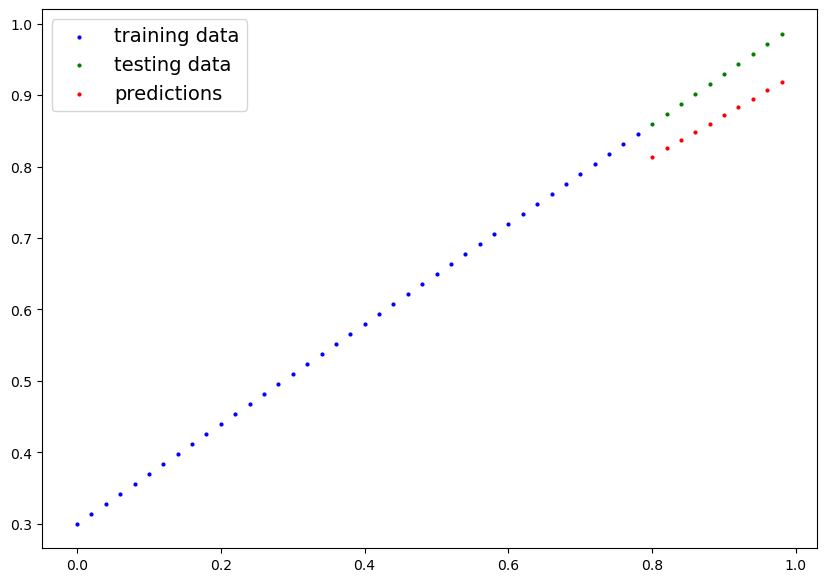

In [198]:
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)

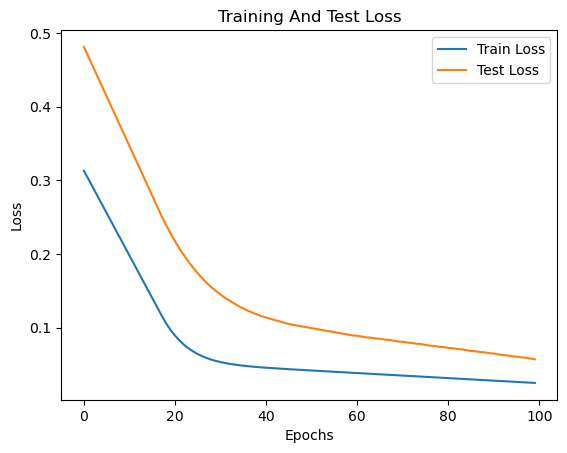

In [199]:
# plotting the loss curves
plt.plot(epochs_list, torch.tensor(train_loss_list).numpy(), label="Train Loss")
plt.plot(epochs_list, torch.tensor(test_loss_list).numpy(), label="Test Loss")
plt.title("Training And Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 6. Saving And Reloading Model
__Resource - https://pytorch.org/tutorials/beginner/saving_loading_models.html__

There are 3 main methods you should know for saving and loading models in PyTorch
1. `torch.save()` - allows you save a pytorch object in python's pickle format
> __torch.save() - https://pytorch.org/docs/stable/generated/torch.save.html#torch-save__
2. `torch.load()` - allows you load a saved pytorch object
> __torch.load() - https://pytorch.org/docs/stable/generated/torch.load.html__
3. `torch.nn.Module.load_state_dict()` - allows to load model's saved state dict

__Saving Model__

In [202]:
MODEL_NAME = "model_0.pth" # if we want to give path we can give here only - "PATH/MODEL_NAME"
torch.save(obj=model_0.state_dict(), f=MODEL_NAME)

__Loading Model__ <br>
Since we saved out model's state_dict() rather than the entire model, we have to create a new instance of our model class and load the saved state_dict() into that.

In [203]:
loaded_model_0 = LinearRegressionModel()
print(f"Before Loading State Dict: {loaded_model_0.state_dict()}")

# load the saved state_dict() to this new instance of the model
loaded_model_0.load_state_dict(torch.load(f=MODEL_NAME))
print(f"After Loading State Dict: {loaded_model_0.state_dict()}")

Before Loading State Dict: OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
After Loading State Dict: OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])
